# Week4 homework-Disaster Tweets


**Problem Description**

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).


**Github URL**

https://github.com/rayangela528/DeepLearning-Disaster-Tweets



**Dataset Description**

DataSource: [Natural Language Processing with Disaster Tweets on Kaggle](https://www.kaggle.com/c/nlp-getting-started/) 

We will start by reading in the training dataset. This csv has over 7,000 tweets that contain the text of the tweet as well as the target value. If the target value is 1, then the tweet is about a real disaster. If the target value is 0, then the tweet is not about a real disaster. We will create a dataframe containing the training data and a separate dataframe containing the test data for future use, which doesn't contain any target values.

DataSize: TrainSet:7,000 tweets
Target:label(0/1)



**Analysis and Modeling Process**

I will load the dataset, perform EDA
1. Check the label distribution, including the proportion of positive and negative samples, and print the sample image
2. data cleaning, check whether there are missing
3. select the model, choose RNN(LSTM) as the baseline model



**Model Training**

Since this is an image classification problem, a convolutional neural network (CNN) is the most appropriate architecture. We choose the following model:
Base CNN: Serves as the baseline model.
Pre-trained models (e.g. ResNet50) : Leverage transfer learning to improve performance.



**Conclusion**

LSTMS

* F1 Score: 0.7334
* Precision: 0.7669
* Recall: 0.7028


Bidirectional LSTM model

* F1 Score: 0.6972
* Precision: 0.7536
* Recall: 0.6486

Comparative analysis

The LSTM model performs better on F1 Score and Recall, indicating that it can better balance Precision and Recall.

The bidirectional LSTM model has higher Precision but lower Recall, indicating that it may be too conservative and miss some positive class samples.


**mprovements that can be made**


Increase the amount of data: Use more training data (e.g. data augmentation or external data).

Handling class imbalance: Data augmentation techniques are used to increase the diversity of minority class samples.

Adjusting model architecture :LSTM models can try to increase the number of LSTM cells or add more layers. Bidirectional LSTM model, can try to reduce the Dropout rate or increase the number of LSTM cells.

Hyperparameter tuning:

Try different learning rates (e.g. 0.001, 0.0001).

Try different batch sizes (e.g., 32, 64, 128).

Try different Dropout rates (e.g., 0.3, 0.4, 0.5).


# Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import random
import shutil
from PIL import Image
import re
import nltk
from nltk.corpus import stopwords
import missingno as msno
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import keras_nlp
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.layers import Bidirectional

# Exploratory data analysis（EDA）

1. Loading data and view
2. Columns
id - a unique identifier for each tweet
text - the text of the tweet
location - the location the tweet was sent from (may be blank)
keyword - a particular keyword from the tweet (may be blank)
target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [2]:
# 加载数据
train_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_data = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
#/kaggle/input/nlp-getting-started/sample_submission.csv
#/kaggle/input/nlp-getting-started/train.csv
#/kaggle/input/nlp-getting-started/test.csv

# 查看数据
print(f"训练集大小: {len(train_data)}")
print(f"测试集大小: {len(test_data)}")

print(f"正样本比例: {train_data['target'].mean():.2f}")

train_data.head()

训练集大小: 7613
测试集大小: 3263
正样本比例: 0.43


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [4]:
print(train_data.shape)
print('')
print(test_data.shape)

(7613, 5)

(3263, 4)


**EDA**

2. Viewing Data 

* Viewing the data distribution（查看数据分布）
* Look at the label distribution:proportion of positive and negative samples（查看标签分布）
* Visualize some sample images（可视化一些样本图像）

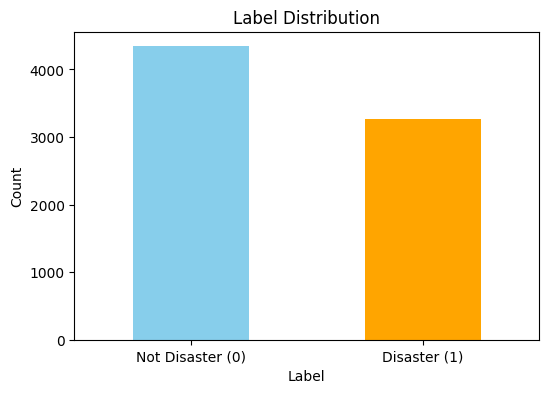

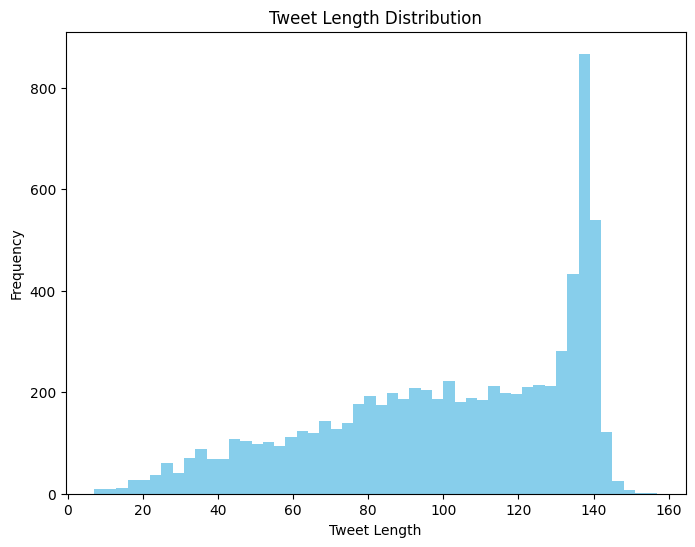

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


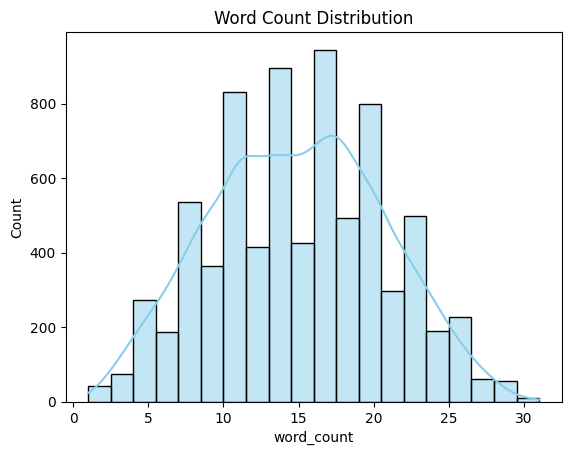

In [5]:
# 标签分布
plt.figure(figsize=(6, 4))
train_data['target'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Disaster (0)', 'Disaster (1)'], rotation=0)
plt.show()

# 推文长度分布
train_data['text_length'] = train_data['text'].apply(len)
plt.figure(figsize=(8, 6))
plt.hist(train_data['text_length'], bins=50, color='skyblue')
plt.title('Tweet Length Distribution')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

train_data['word_count'] = train_data['text'].apply(lambda x: len(str(x).split()))

# Plot histogram
sns.histplot(train_data['word_count'], bins=20, kde=True, color='skyblue')
plt.title('Word Count Distribution')
plt.show()

**EDA**

3. Data Clean

* Check for missing values（检查是否有缺失值）
* Fill

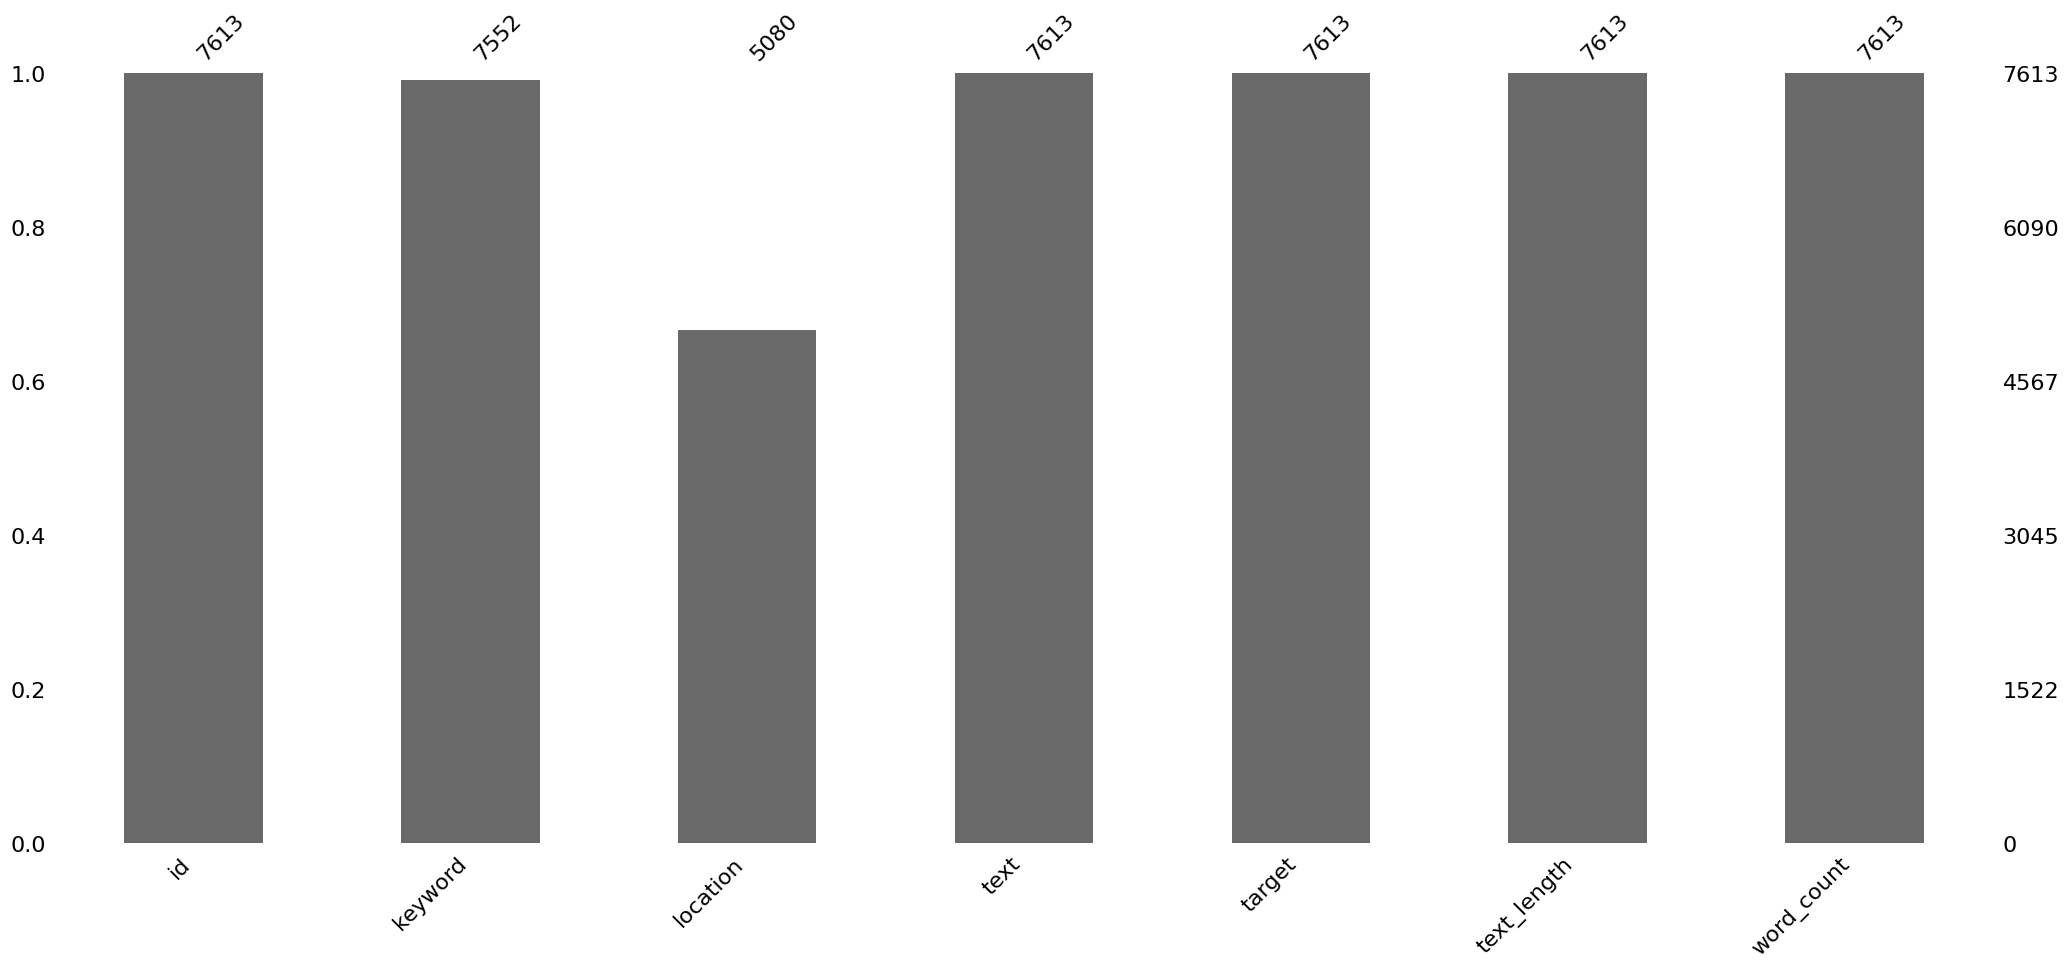

Missing values in training data:
 id                0
keyword          61
location       2533
text              0
target            0
text_length       0
word_count        0
dtype: int64

Missing values after filling:
 id             0
keyword        0
location       0
text           0
target         0
text_length    0
word_count     0
dtype: int64

Sample Disaster Tweets:
['Nearly 50 thousand people affected by floods in #Paraguay ? http://t.co/aw23wXtyjB http://t.co/ABgct9VFUa'
 'Vladimir Putin Issues Major Warning But Is It Too Late To Escape Armageddon?\nhttp://t.co/gBxafy1m1C'
 "@DoctorFluxx @StefanEJones @spinnellii @themermacorn  No burning buildings and rob during a riot. That's embarrassing &amp; ruining this nation."
 'Telnet attacked from 124.13.172.40 (STREAMYX-HOME-SOUTHERN MY)'
 'LONDON IS DROWNING AND IIII LIVE BY THE RIVEEEEEER']

Sample Non-Disaster Tweets:
['Everyday is a near death fatality for me on the road. Thank god is on my side.??'
 '#Lifestyle \x89Û÷It makes m

<ipython-input-6-b0caa8634eca>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data["keyword"].fillna("unknown", inplace=True)
<ipython-input-6-b0caa8634eca>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

In [6]:
# Check for missing values
msno.bar(train_data)
plt.show()

print("Missing values in training data:\n", train_data.isnull().sum())
# Fill missing values in 'keyword' and 'location'
train_data["keyword"].fillna("unknown", inplace=True)
train_data["location"].fillna("unknown", inplace=True)
train_data["keyword"].fillna("unknown", inplace=True)
train_data["location"].fillna("unknown", inplace=True)
print("\nMissing values after filling:\n", train_data.isnull().sum())

print("\nSample Disaster Tweets:")
print(train_data[train_data["target"] == 1]["text"].sample(5, random_state=42).values)
print("\nSample Non-Disaster Tweets:")
print(train_data[train_data["target"] == 0]["text"].sample(5, random_state=42).values)

**Clean Text**

In [7]:
# 下载停用词
nltk.download('stopwords')
stemmer=nltk.SnowballStemmer("english")
stopword=set(stopwords.words("english"))
def clean_text(df,text_column):
    # Convert to lowercase
    df[text_column] = df[text_column].str.lower()
    
    # Remove unwanted characters
    df[text_column] = df[text_column].str.replace('[^\w\s]', '', regex=True)
    df[text_column] = df[text_column].str.replace('\w*\d\w*', '', regex=True)
    df[text_column] = df[text_column].str.replace('\n', '', regex=True)
    df[text_column] = df[text_column].str.replace('\r', '', regex=True)
    df[text_column] = df[text_column].str.replace('https?://\S+|www\.\S+', '', regex=True)
    df[text_column] = df[text_column].str.replace('<.*?>+', '', regex=True)
    df[text_column] = df[text_column].str.replace('\[.*?\]', '', regex=True)
    
    # Remove stopwords and apply stemming
    df[text_column] = df[text_column].apply(lambda x: ' '.join(
        stemmer.stem(word) 
        for word in x.split() 
        if word not in stopword
    ))
    return df[text_column]

# 清理文本
train_data["cleaned_text"]=clean_text(train_data,"text")
test_data["cleaned_text"]=clean_text(test_data,"text")

print(f": {len(train_data['cleaned_text'])}")
print(f": {len(test_data['cleaned_text'])}")


[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
: 7613
: 3263


**Initializing parameters**

In [8]:
MAX_LEN = 5000
# 文本向量化
tokenizer = Tokenizer(num_words=MAX_LEN, oov_token="<OOV>") 
tokenizer.fit_on_texts(train_data["cleaned_text"])

train_sequences = tokenizer.texts_to_sequences(train_data['cleaned_text'])
test_sequences = tokenizer.texts_to_sequences(test_data["cleaned_text"])

train_padded = pad_sequences(train_sequences, maxlen=50, padding="post")
test_padded = pad_sequences(test_sequences, maxlen=50, padding="post")

print("实例序列:", train_sequences[0])
print("填充序列:", train_padded[0])

y_train = train_data['target']

# 使用train_test_split从训练集分割出验证集
#X_train, X_val, y_train, y_val = train_test_split(train_padded, y_train, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(train_padded, y_train, test_size=0.2, random_state=66)

# Show dataset shapes
#print("Training set shape:", X_train.shape)
#print("Validation set shape:", X_val.shape)

# 检查数据形状
print(f"X_train 形状: {X_train.shape}")
print(f"y_train 形状: {y_train.shape}")
print(f"X_val 形状: {X_val.shape}")
print(f"y_val 形状: {y_val.shape}")

实例序列: [3682, 474, 210, 87, 1475, 2904, 19]
填充序列: [3682  474  210   87 1475 2904   19    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
X_train 形状: (6090, 50)
y_train 形状: (6090,)
X_val 形状: (1523, 50)
y_val 形状: (1523,)


# Model building（RNN）

Since this is a sequence classification problem, RNN (especially LSTM or GRU) is a suitable choice. Here is the architecture of the model:


In [9]:
# 构建 LSTM 模型
model_lstm = Sequential([
    Embedding(input_dim=MAX_LEN, output_dim=128, input_length=50),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


# 编译模型
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 传入一些数据以推断形状
dummy_input = np.zeros((1, 50))  # 创建一个形状为 (1, 50) 的虚拟输入
model_lstm(dummy_input)  # 动态推断形状

# 打印模型摘要
model_lstm.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (1, 50, 128)                │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (1, 128)                    │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (1, 128)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (1, 64)                     │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (1, 64)                     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (1, 1)                      │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 779,905 (2.98 MB)

 Trainable params: 779,905 (2.98 MB)

 Non-trainable params: 0 (0.00 B)

# Model training（模型训练）

Training a model（训练模型）
Since the data size is small, we can reduce the number of training epochs（由于数据量较小，我们可以减少训练轮数）

In [10]:
print(f"X_train 形状: {X_train.shape}")
print(f"X_val 形状: {X_val.shape}")
print(f"X_train 最小值: {np.min(X_train)}")
print(f"X_train 最大值: {np.max(X_train)}")
print(f"X_val 最小值: {np.min(X_val)}")
print(f"X_val 最大值: {np.max(X_val)}")
vocab_size = len(tokenizer.word_index) + 1
print(f"词汇表大小: {vocab_size}")
print(f"X_train 序列长度: {X_train.shape[1]}")
print(f"X_val 序列长度: {X_val.shape[1]}")

# 训练 LSTM 模型
history_lstm = model_lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    verbose=1
)

X_train 形状: (6090, 50)
X_val 形状: (1523, 50)
X_train 最小值: 0
X_train 最大值: 4999
X_val 最小值: 0
X_val 最大值: 4999
词汇表大小: 14538
X_train 序列长度: 50
X_val 序列长度: 50
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.5625 - loss: 0.6888 - val_accuracy: 0.5758 - val_loss: 0.6824
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.5755 - loss: 0.6851 - val_accuracy: 0.5758 - val_loss: 0.6817
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.5734 - loss: 0.6841 - val_accuracy: 0.5758 - val_loss: 0.6824
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.5645 - loss: 0.6866 - val_accuracy: 0.5758 - val_loss: 0.6830
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.5595 - loss: 0.6870 - val_accuracy: 0.5758 - val_loss: 0.6820
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.5777 - loss: 0.6833 - val_accuracy: 0.5758 - val_loss: 0.6824
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.5586 - loss: 0.6865 - 

In [11]:
# 在验证集上预测
y_pred_lstm = (model_lstm.predict(X_val) > 0.5).astype(int)

# 计算 F1、Precision 和 Recall
f1_lstm = f1_score(y_val, y_pred_lstm)
precision_lstm = precision_score(y_val, y_pred_lstm)
recall_lstm = recall_score(y_val, y_pred_lstm)

# 打印结果
print(f"LSTM 模型结果:")
print(f"F1 Score: {f1_lstm:.4f}")
print(f"Precision: {precision_lstm:.4f}")
print(f"Recall: {recall_lstm:.4f}")



#make predictions
# Predict on test data
test_predictions = (model_lstm.predict(test_padded) > 0.5).astype(int)

# Prepare submission file
submission = pd.DataFrame({"id": test_data["id"], "target": test_predictions.flatten()})
submission.to_csv("submission.csv", index=False)

# Show first few rows
submission.head(20)



48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
LSTM 模型结果:
F1 Score: 0.7334
Precision: 0.7669
Recall: 0.7028
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


**Visualizing training results（可视化训练结果）**

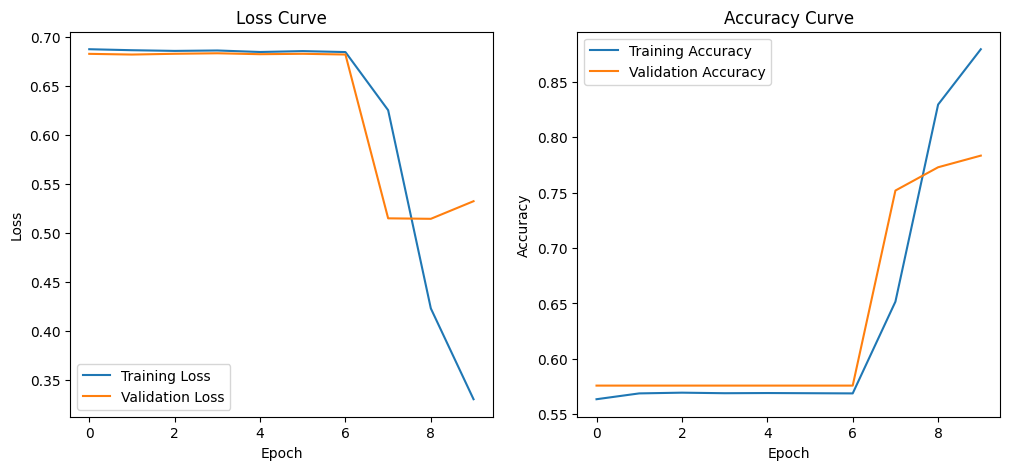

In [12]:
# 绘制训练和验证的损失和准确率曲线
plt.figure(figsize=(12, 5))

# 损失曲线
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 准确率曲线
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


# Model building（双向 LSTM 模型）

In [18]:

# 构建双向 LSTM 模型
model_bilstm = Sequential([
    Embedding(input_dim=MAX_LEN, output_dim=128, input_length=MAX_LEN),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_bilstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 传入一些数据以推断形状
dummy_input = np.zeros((1, 50))  # 创建一个形状为 (1, 50) 的虚拟输入
model_bilstm(dummy_input)  # 动态推断形状

model_bilstm.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (1, 50, 128)                │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (1, 256)                    │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (1, 256)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (1, 64)                     │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (1, 64)                     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (1, 1)                      │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 919,681 (3.51 MB)

 Trainable params: 919,681 (3.51 MB)

 Non-trainable params: 0 (0.00 B)

**模型训练与评估**

In [19]:
# 训练双向 LSTM 模型
history_bilstm = model_bilstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    verbose=1
)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.6093 - loss: 0.6523 - val_accuracy: 0.7892 - val_loss: 0.4713
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - accuracy: 0.8487 - loss: 0.3691 - val_accuracy: 0.7814 - val_loss: 0.4806
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.8969 - loss: 0.2723 - val_accuracy: 0.7787 - val_loss: 0.5878
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.9317 - loss: 0.1933 - val_accuracy: 0.7715 - val_loss: 0.6487
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.9473 - loss: 0.1565 - val_accuracy: 0.7557 - val_loss: 0.7066
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.9548 - loss: 0.1311 - val_accuracy: 0.7564 - val_loss: 1.0250
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.9579 - loss: 0.1084 - val_accuracy: 0.7511 - val_loss: 1.1238
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.9635 - loss: 0.0846 - val_accuracy: 0.7571 -

In [24]:

# 在验证集上预测
y_pred_bilstm = (model_bilstm.predict(X_val) > 0.5).astype(int)

# 计算 F1、Precision 和 Recall
f1_bilstm = f1_score(y_val, y_pred_bilstm)
precision_bilstm = precision_score(y_val, y_pred_bilstm)
recall_bilstm = recall_score(y_val, y_pred_bilstm)

# 打印结果
print(f"双向 LSTM 模型结果:")
print(f"F1 Score: {f1_bilstm:.4f}")
print(f"Precision: {precision_bilstm:.4f}")
print(f"Recall: {recall_bilstm:.4f}")


#make predictions
# Predict on test data
test_bil_predictions = (model_bilstm.predict(test_padded) > 0.5).astype(int)

# Prepare submission file
submission_bil = pd.DataFrame({"id": test_data["id"], "target": test_bil_predictions.flatten()})
submission_bil.to_csv("submission_bil.csv", index=False)

# Show first few rows
submission_bil.head(20)


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
双向 LSTM 模型结果:
F1 Score: 0.6972
Precision: 0.7536
Recall: 0.6486
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


**可视化训练结果**

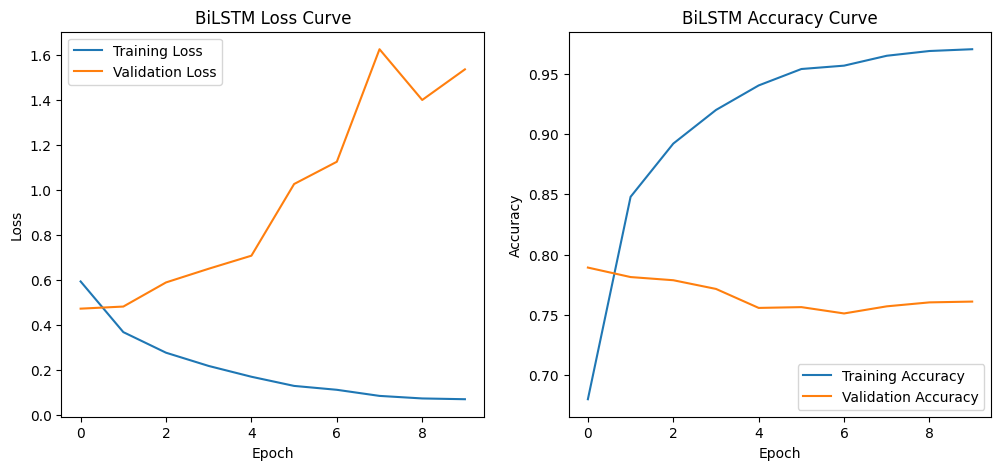

In [21]:
# 绘制训练和验证的损失和准确率曲线
plt.figure(figsize=(12, 5))

# 损失曲线
plt.subplot(1, 2, 1)
plt.plot(history_bilstm.history['loss'], label='Training Loss')
plt.plot(history_bilstm.history['val_loss'], label='Validation Loss')
plt.title('BiLSTM Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 准确率曲线
plt.subplot(1, 2, 2)
plt.plot(history_bilstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_bilstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('BiLSTM Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Conclusion

    Model  F1 Score  Precision    Recall
    
0    LSTM  0.733441   0.766892  0.702786

1  BiLSTM  0.697171   0.753597  0.648607

Current results: The F1 Score of the LSTM model is 0.7334, which is better than the 0.6972 of the bidirectional LSTM model.

Directions for improvement: Increase the amount of data, use pre-trained word vectors, adjust hyperparameters, etc.

    Model  F1 Score  Precision    Recall
0    LSTM  0.733441   0.766892  0.702786
1  BiLSTM  0.697171   0.753597  0.648607


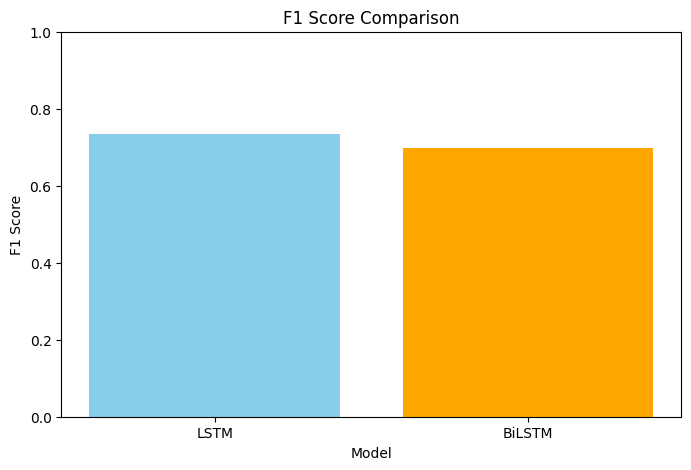

In [22]:
# 创建结果表格
results = pd.DataFrame({
    'Model': ['LSTM', 'BiLSTM'],
    'F1 Score': [f1_lstm, f1_bilstm],
    'Precision': [precision_lstm, precision_bilstm],
    'Recall': [recall_lstm, recall_bilstm]
})

print(results)



# 绘制 F1 Score 对比图
plt.figure(figsize=(8, 5))
plt.bar(results['Model'], results['F1 Score'], color=['skyblue', 'orange'])
plt.title('F1 Score Comparison')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.show()